In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [131]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


In [132]:
data.SppN.mean()

5.1824128104220382

In [133]:
import geopandas as gpd

In [134]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [135]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [136]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [137]:
#new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [138]:
##### OLD #######
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
#X = data[['SppN','lon','lat']]
X = data[['lon','lat']]
#Y = data['plotBiomass']
Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
#import numpy as np
#sample_size = 2000
#randindx = np.random.randint(0,X.shape[0],sample_size)
#nX = X.loc[randindx]
#nY = Y.loc[randindx]
nX = X
nY = Y



In [139]:
## Small function for systematically selecting the k-th element of the data.
#### Sughgestion use for now a small k i.e. 10
systematic_selection = lambda k : filter(lambda i : not(i % 10) ,range(len(data))) 

In [140]:
idx = systematic_selection(7)
nX = X.loc[idx]
nY = Y.loc[idx]
new_data = data.loc[idx]

In [141]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [142]:
model = gf.gpr.GPR(nX.as_matrix(),nY.as_matrix().reshape(len(nY),1).astype(float),k)


## Fitted parameters (From HEC)

In [143]:
model.kern.lengthscales = 25.4846122373
model.kern.variance = 10.9742076021
model.likelihood.variance = 4.33463026664

In [144]:
%time mm = k.compute_K_symm(X.as_matrix())

CPU times: user 47 s, sys: 3.8 s, total: 50.8 s
Wall time: 14.4 s


In [145]:
import numpy as np
Nn = 500
dsc = data
predicted_x = np.linspace(min(dsc.lon),max(dsc.lon),Nn)
predicted_y = np.linspace(min(dsc.lat),max(dsc.lat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [146]:
len(predicted_coordinates)

250000

In [20]:
#We will calculate everything with the new model and parameters
#model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(len(Y),1).astype(float),k)

In [147]:
%time means,variances = model.predict_y(predicted_coordinates)

CPU times: user 5min 58s, sys: 6.96 s, total: 6min 5s
Wall time: 5min 22s


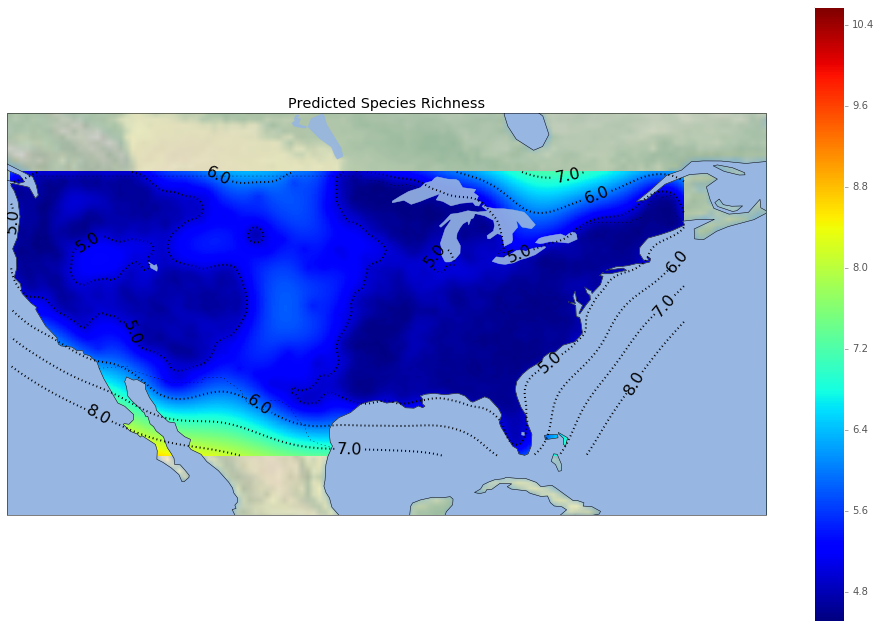

# Predictions with +2std.Dev

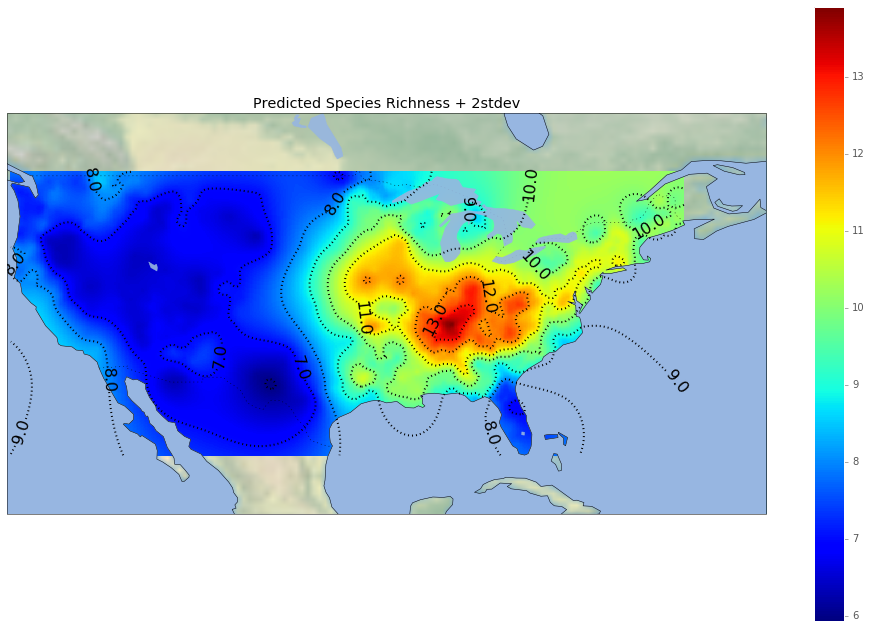

In [173]:
#Using k-partition = 7
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-125, -60, 20, 50])
#ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn) + (2* np.sqrt(variances).reshape(Nn,Nn)),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn) + (2 * np.sqrt(variances).reshape(Nn,Nn)),linewidths=2,colors='k',linestyles='dotted',levels=range(1,20))
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,edgecolors='',color='white',alpha=0.6)
plt.colorbar(mm)
plt.title("Predicted Species Richness + 2stdev")

# Predicted means

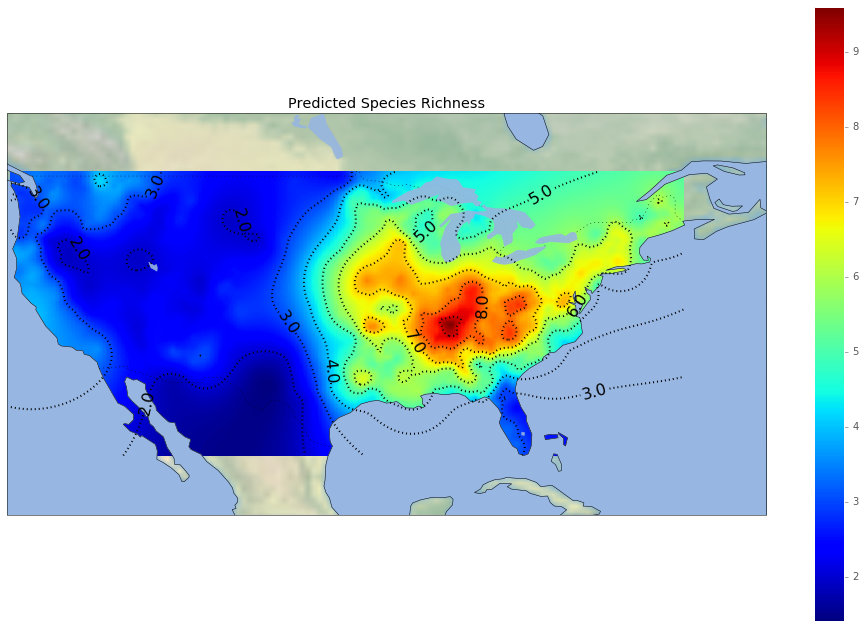

In [174]:
#Using k-partition = 7
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-125, -60, 20, 50])
#ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=range(1,20))
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,edgecolors='',color='white',alpha=0.6)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


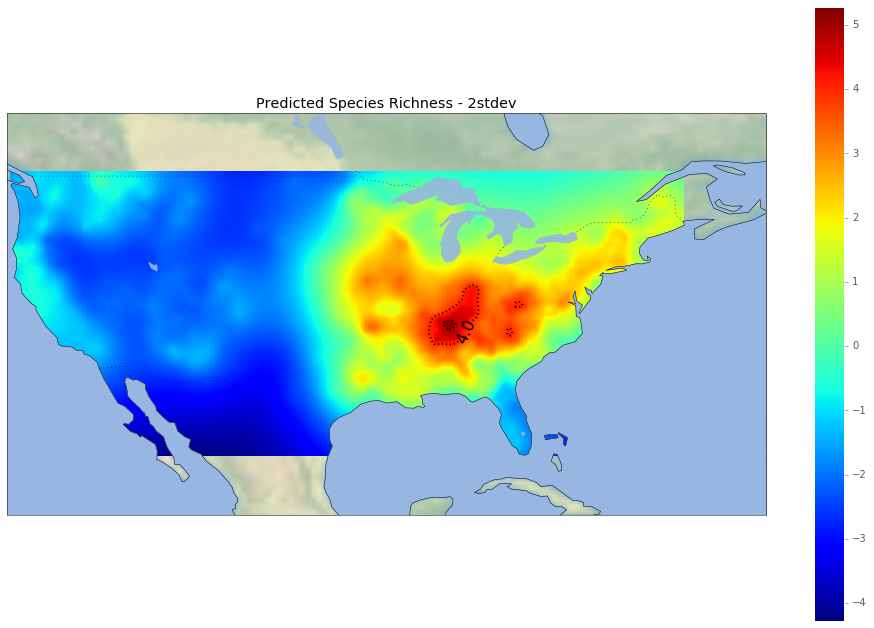

In [150]:
#Using k-partition = 7
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
ax.set_extent([-125, -60, 20, 50])
#ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn) - (2* np.sqrt(variances).reshape(Nn,Nn)),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn) - (2 * np.sqrt(variances).reshape(Nn,Nn)),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,edgecolors='',color='white',alpha=0.6)
plt.colorbar(mm)
plt.title("Predicted Species Richness - 2stdev")

## Model Analysis


In [151]:
model.get_parameter_dict()

{'name.kern.lengthscales': array([ 25.48461224]),
 'name.kern.variance': array([ 10.9742076]),
 'name.likelihood.variance': array([ 4.33463027])}

## Let's calculate the residuals

In [152]:
X_ = data[['LON','LAT']]
%time Y_hat = model.predict_y(X_)

CPU times: user 53.5 s, sys: 1.36 s, total: 54.8 s
Wall time: 48.3 s


In [153]:
pred_y = pd.DataFrame(Y_hat[0])
var_y = pd.DataFrame(Y_hat[1])

In [154]:
new_data['pred_y'] = pred_y
new_data['var_y'] = var_y

In [155]:
new_data= new_data.assign(error=lambda y : (y.SppN - y.pred_y)**2 )

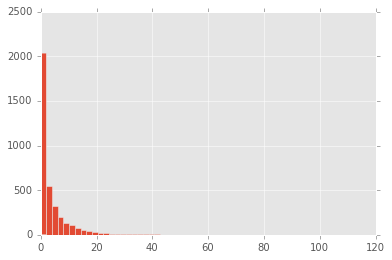

In [156]:
new_data.error.hist(bins=50)

In [157]:
print(new_data.error.mean())
print(new_data.error.std())

4.22043980672
7.01996573172


## Experiment
In this section we will bring a Raster Data from the US, using Biospytial Raster API. 
1. First select a polygon, then get A Raster FRom there, say Mean Temperature.

In [2]:
import raster_api.tools as rt
from raster_api.models import MeanTemperature,ETOPO1,Precipitation,SolarRadiation
from sketches.models import Country


In [3]:
## Select US
us_border = Country.objects.filter(name__contains='United States')[1]

In [167]:
from django.db import close_old_connections

In [168]:
close_old_connections()

In [4]:
#Get Raster API
us_meantemp = rt.RasterData(Precipitation,us_border.geom)
us_meantemp.getRaster()

OperationalError: SSL SYSCALL error: EOF detected


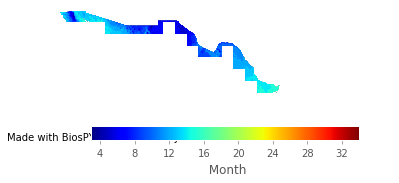

In [124]:
us_meantemp.display_field()

In [110]:
%time coords = us_meantemp.getCoordinates()

CPU times: user 5min 10s, sys: 8.22 s, total: 5min 19s
Wall time: 5min 19s


67795328